In [1]:
import tensorflow as tf
import numpy as np
import time
import pandas as pd
import math
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import wandb
import os 

# set random seed
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

tf.compat.v1.disable_eager_execution()

# Initializing wandb functionality

In [2]:
!wandb login --relogin
# Copy and paste this api key: 822244d22c29151b0b6501c81c4e22a5c5a0843f
global entity_name
global project_name

entity_name="vamsi_malineni6"
project_name="fds_surr_96_checking_normalization"

wandb.init(entity=entity_name,project=project_name)
# Finish the dummy run started after first initializing
wandb.run.finish()

# # Delete the dummy run from the wandb workspace 
# api=wandb.Api()
# run_id=wandb.run.id
# run=ap.run(str(entity_name)+"/"+str(project_name)+"/"+str(run_id))
# run.delete()

'wandb' is not recognized as an internal or external command,
operable program or batch file.
wandb: Currently logged in as: vamsi_malineni6. Use `wandb login --relogin` to force relogin


In [3]:
class bc_pinn_t0:
    # Initialize the class
    def __init__(self,domain,initial,boundary,domaindata,datalist,lowb,upb,
                 ntrain,batch_size,layers,re,
                 load_model=False,filedr='',freeze=0,timestep=0,
                 savewandb='',saveloss='',gradname=''):
        
        self.domain   = domain
        self.initial  = initial
        self.boundary = boundary
        self.datalist = datalist
        self.domain_data = domaindata
        
        self.freeze   = freeze
        self.time_step = timestep
        
        self.params_name = savewandb
        self.loss_name   = saveloss
        self.gradient_name= gradname
        
        self.ntrain = ntrain
        self.batch_size= batch_size
        
        # Calling domain data for initializing the neural network before entering the Adam optimization
        self.xa=self.domain[:,0].reshape(self.domain[:,0].shape[0],1)
        self.ya=self.domain[:,1].reshape(self.domain[:,1].shape[0],1)
        self.ta=self.domain[:,2].reshape(self.domain[:,2].shape[0],1)
        self.ua=self.domain_data[:,3].reshape(self.domain_data[:,3].shape[0],1)
        self.va=self.domain_data[:,4].reshape(self.domain_data[:,4].shape[0],1)
        
        
        self.lowb = lowb
        self.upb = upb
        
        # Calling boundary and initial conditions data as they dont change through the adam iterations
                
        self.x0=self.initial[:,0].reshape(self.initial[:, 0].shape[0], 1)
        self.y0=self.initial[:,1].reshape(self.initial[:, 1].shape[0], 1)
        self.t0=self.initial[:,2].reshape(self.initial[:, 2].shape[0], 1)
        self.u0=self.initial[:,3].reshape(self.initial[:, 3].shape[0], 1)
        self.v0=self.initial[:,4].reshape(self.initial[:, 4].shape[0], 1)
        
        self.xb=self.boundary[:,0].reshape(self.boundary[:, 0].shape[0], 1)
        self.yb=self.boundary[:,1].reshape(self.boundary[:, 1].shape[0], 1)
        self.tb=self.boundary[:,2].reshape(self.boundary[:, 2].shape[0], 1)
        self.ub=self.boundary[:,3].reshape(self.boundary[:, 3].shape[0], 1)
        self.vb=self.boundary[:,4].reshape(self.boundary[:, 4].shape[0], 1)
        
  
        self.layers = layers
        self.re = re

        # Initialize NN
        if load_model ==False:
            self.weights, self.biases = self.initialize_NN(self.layers)
        else:
            self.weights,self.biases = self.load_parameters(filedr,self.layers)
            
        

        # tf placeholders and graph
        
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
        
        # Initial conditions placeholders
        self.x_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.u_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        # Boundary conditions placeholders
        self.x_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.t_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        self.u_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.vb.shape[1]])
        
        # Domain placeholders having the size of batch_size
        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        # Domain data placeholders 
        self.xdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.ydata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.tdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        self.udata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ua.shape[1]])
        self.vdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.va.shape[1]])
        
        # Initial conditions predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred =\
            self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        # Boundary conditions predictions
        self.u_boundary_pred, self.v_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.t_boundary_tf)
        
        # Domain data predictions
        self.u_dom_pred,self.v_dom_pred,_=\
            self.net_NS(self.xdata_tf,self.ydata_tf,self.tdata_tf)
        
        # Domain predictions
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

        # Adaptive reweighting constants
        self.alpha, self.beta, self.gamma = 0.9,0.9,0.9
        
        self.adaptive_constant_ics_val= np.array(1.0)
        self.adaptive_constant_bcs_val= np.array(1.0)
        self.adaptive_constant_dds_val= np.array(1.0)
        
        self.adaptive_constant_ics_tf =tf.compat.v1.placeholder(tf.float32, shape=self.adaptive_constant_ics_val.shape)
        self.adaptive_constant_bcs_tf =tf.compat.v1.placeholder(tf.float32, shape=self.adaptive_constant_bcs_val.shape)
        self.adaptive_constant_dds_tf =tf.compat.v1.placeholder(tf.float32, shape=self.adaptive_constant_dds_val.shape)

        # set loss function
        self.initial_loss  = self.adaptive_constant_ics_tf * tf.reduce_mean(input_tensor=tf.square(self.u_ini_tf - self.u_ini_pred)) + \
                             self.adaptive_constant_ics_tf * tf.reduce_mean(input_tensor=tf.square(self.v_ini_tf - self.v_ini_pred))
        
        self.boundary_loss = self.adaptive_constant_bcs_tf * tf.reduce_mean(input_tensor=tf.square(self.u_boundary_tf - self.u_boundary_pred)) + \
                             self.adaptive_constant_bcs_tf * tf.reduce_mean(input_tensor=tf.square(self.v_boundary_tf - self.v_boundary_pred))

        self.domdata_loss  = self.adaptive_constant_dds_tf * tf.reduce_mean(input_tensor=tf.square(self.udata_tf - self.u_dom_pred)) + \
                             self.adaptive_constant_dds_tf * tf.reduce_mean(input_tensor=tf.square(self.vdata_tf - self.v_dom_pred))

        self.residual_loss = tf.reduce_mean(input_tensor=tf.square(self.f_u_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_v_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_e_pred))

        
        
        self.loss =  self.initial_loss + self.boundary_loss + self.residual_loss + self.domdata_loss
        
        self.loss_i=[]
        self.loss_b=[]
        self.loss_r=[]
        self.loss_d=[]

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
#===========================================================================================================#
#=================================Saving gradients==========================================================#
#===========================================================================================================#
        # saving gradients of residual, boundary conditions, initial conditions, domain data
        self.dict_gradients_res_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_bcs_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_ics_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_dds_layers = self.generate_grad_dict(self.layers)

        # storing gradients 
        self.grad_res = []
        self.grad_bcs = []
        self.grad_ics = []
        self.grad_dds = []

        for i in range(len(self.layers)-1):
            self.grad_res.append(tf.gradients(ys=self.residual_loss, xs=self.weights[i])[0])
            self.grad_bcs.append(tf.gradients(ys=self.boundary_loss, xs=self.weights[i])[0])
            self.grad_ics.append(tf.gradients(ys=self.initial_loss,  xs=self.weights[i])[0])
            self.grad_dds.append(tf.gradients(ys=self.domdata_loss,  xs=self.weights[i])[0])
        
        # Calculating weights
        self.adaptive_constant_bcs_list=[]
        self.adaptive_constant_ics_list=[]
        self.adaptive_constant_dds_list=[]
        
        for i in range(len(self.layers)-1):
            self.adaptive_constant_bcs_list.append(
                tf.reduce_max(tf.abs(self.grad_res[i]))/ tf.reduce_mean(tf.abs(self.grad_bcs[i])))
            self.adaptive_constant_ics_list.append(
                tf.reduce_max(tf.abs(self.grad_res[i]))/ tf.reduce_mean(tf.abs(self.grad_ics[i])))
            self.adaptive_constant_dds_list.append(
                tf.reduce_max(tf.abs(self.grad_res[i]))/ tf.reduce_mean(tf.abs(self.grad_dds[i])))

        self.adaptive_constant_bcs = tf.reduce_max(tf.stack(self.adaptive_constant_bcs_list))
        self.adaptive_constant_ics = tf.reduce_max(tf.stack(self.adaptive_constant_ics_list))
        self.adaptive_constant_dds = tf.reduce_max(tf.stack(self.adaptive_constant_dds_list))
            
    def generate_grad_dict(self,layers):
        num = len(layers)-1
        grad_dict={}
        for i in range(num):
            grad_dict['layer_{}'.format(i+1)]=[]
        return grad_dict
    
    def save_gradients(self,tf_dict):
        num_layers=len(self.layers)
        for i in range(num_layers-1):
            grad_res_value,grad_bcs_value,grad_ics_value,grad_dds_value = self.sess.run([self.grad_res[i],self.grad_bcs[i],self.grad_ics[i],self.grad_dds[i]],feed_dict=tf_dict)
            
            self.dict_gradients_res_layers['layer_'+str(i+1)].append(grad_res_value.flatten())
            self.dict_gradients_bcs_layers['layer_'+str(i+1)].append(grad_bcs_value.flatten())
            self.dict_gradients_ics_layers['layer_'+str(i+1)].append(grad_ics_value.flatten())
            self.dict_gradients_dds_layers['layer_'+str(i+1)].append(grad_dds_value.flatten())
        return None
    
    def save_gradients_infile(self,fileDr):    
        res=self.dict_gradients_res_layers
        bcs=self.dict_gradients_bcs_layers
        ics=self.dict_gradients_ics_layers
        dds=self.dict_gradients_dds_layers

        with open(fileDr,'wb') as f:
            pickle.dump([res,bcs,ics,dds],f)
            print("Gradients are saved in pickle file")
    
    def save_weights(self,fileDr):
        with open(fileDr, 'wb') as f:
            b=self.adaptive_constant_bcs_val
            i=self.adaptive_constant_ics_val
            d=self.adaptive_constant_dds_val
            pickle.dump([b,i,d],f)
            print("Adaptive weights are saved in pickle file")


#===========================================================================================================#
#====================================Transfer Learning======================================================#
#===========================================================================================================#
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
        with open(fileDr,'wb') as f:
            pickle.dump([weights,biases],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        # returns the weights and biases of the network as np array
        with open(fileDr,'rb') as f:
            weights,biases=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            tf_weights.append ( tf.Variable (weights[num],trainable ='True' ))
            tf_biases.append  ( tf.Variable (biases[num],trainable ='True' ))
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases
    
#===========================================================================================================#
#========================================saving loss values=================================================#
#===========================================================================================================#
    def save_loss(self,fileDr,tf_dict):
        self.loss_i.append(self.sess.run(self.initial_loss,tf_dict))
        self.loss_b.append(self.sess.run(self.boundary_loss,tf_dict))
        self.loss_r.append(self.sess.run(self.residual_loss,tf_dict))
        self.loss_d.append(self.sess.run(self.domdata_loss,tf_dict))
                       
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([self.loss_i,self.loss_b,self.loss_r,self.loss_d],f)
            print("Loss are saved in pickle file")
    
    def load_loss(self,fileDr):
        
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            initial,boundary,residual,datadomain=pickle.load(f)
        
        print("Losses are loaded successfully")
        
        return initial,boundary,residual,datadomain
    

    
#===========================================================================================================#
#===========================================================================================================#
#===========================================================================================================#
 

# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# generate the neural network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
#             H = tf.tanh(tf.add(tf.matmul(H, W), b))
            H = tf.keras.activations.swish(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

# ###################without assume###############
    # supervised data driven
    def net_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        u_t = tf.gradients(ys=u, xs=t)[0] 
        u_x = tf.gradients(ys=u, xs=x)[0] 
        u_y = tf.gradients(ys=u, xs=y)[0] 
        u_xx = tf.gradients(ys=u_x, xs=x)[0] 
        u_yy = tf.gradients(ys=u_y, xs=y)[0] 
        
        v_t = tf.gradients(ys=v, xs=t)[0] 
        v_x = tf.gradients(ys=v, xs=x)[0] 
        v_y = tf.gradients(ys=v, xs=y)[0] 
        v_xx = tf.gradients(ys=v_x, xs=x)[0] 
        v_yy = tf.gradients(ys=v_y, xs=y)[0] 

        p_x = tf.gradients(ys=p, xs=x)[0] 
        p_y = tf.gradients(ys=p, xs=y)[0] 

        f_u = u_t + (u * u_x + v * u_y) + p_x - (1/(10*self.re)) * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - (1/(10*self.re)) * (v_xx + v_yy)
        f_e = u_x + v_y

        return u, v, p, f_u, f_v, f_e

#===========================================================================================================#
#===========================Predicting and finding error every 10 epochs====================================#
#===========================================================================================================#
   
    
    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star
    
    def load_testdata(self,time_step):
        
        # Converting the time_step from decimal to integer 0.1 --> 1
        ts=int(10*time_step)

        # Loading the complete list of data 
        data_list=self.datalist

        # Extracting the data for the given range of time steps [0,0.1] and so on
        dt=0.1
        times=[round(i,3) for i in np.arange(0,7+dt,dt)]

        # Finding the indexes of initial and final timestep from the times list
        t1=times.index(round((time_step-1.0),2))
        t2=times.index(time_step)

        temp=[]
        # Excluding INITIAL DATA from the collocation points, to make sure that the model is not overfitting on
        # initial points, as there is u,v data available for the model. 

        for i in range(t1,t2+1):
            if i<t2+1:
                temp.append(data_list[i])

        # data stores the final timestep data for the given time segment

        data=np.concatenate(temp[4:],axis=0)

        x_star=data[:,0].reshape(data[:,0].shape[0],1)
        y_star=data[:,1].reshape(data[:,1].shape[0],1)
        t_star=data[:,2].reshape(data[:,2].shape[0],1)

        X_star=[x_star,y_star,t_star]

        u_star=data[:,3].reshape(data[:,3].shape[0],1)
        v_star=data[:,4].reshape(data[:,4].shape[0],1)
        p_star=data[:,5].reshape(data[:,5].shape[0],1)

        Y_star=[u_star,v_star,p_star]

        return X_star,Y_star
    
    def find_error(self,test_time_step):
        
        X_star,Y_star=self.load_testdata(test_time_step)
        u_pred,_,_ = self.predict(X_star[0],X_star[1],X_star[2])
        
        error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
        

        return error_u
        
#===========================================================================================================#
#===========================ADAM TRAINING FUNCTION==========================================================#
#===========================================================================================================#
   
#IMPORTANT NOTES for a given TIME SEGMENT consisting of (5*10000=50000) points in the grid.

# (1) Randomly sampling 1000 datapoints every iteration from 38416 collocation points
#     effectively per epoch the model would see 25000 collocation points, which is 65% of sampled colloc points

# (2) Randomly sampling 250 datapoints every iteration from 19208 data points,
#     effectively per epoch the model would see 6250 data points. which is 32% of the sampled data points
 
# (3) The model would see 10000 initial conditions data points per iteration per epoch
#
# (4) The model would see 1584 boundary conditions points per iteration per epoch


    def Adam_train(self, epoch=5000, learning_rate=1e-3):
    
        start_time = time.time()
        
        iters = int(self.ntrain / self.batch_size)
        
        self.adaptive_constant_bcs_log=[]
        self.adaptive_constant_ics_log=[]
        self.adaptive_constant_dds_log=[]
        
        
        for it in range(epoch):
            
            for i in (range(iters)):
            
                idx=  np.random.choice(self.domain.shape[0],self.batch_size,replace=False)
#                 didx= np.random.choice(self.domain_data.shape[0],250,replace=False)
                
                self.data_domain=self.domain[idx,:]
                self.data_driven=self.domain_data
                
                xd=self.data_domain[:,0].reshape(self.data_domain[:, 0].shape[0], 1)
                yd=self.data_domain[:,1].reshape(self.data_domain[:, 1].shape[0], 1)
                td=self.data_domain[:,2].reshape(self.data_domain[:, 2].shape[0], 1)

                xdata=self.data_driven[:,0].reshape(self.data_driven[:, 0].shape[0], 1)
                ydata=self.data_driven[:,1].reshape(self.data_driven[:, 1].shape[0], 1)
                tdata=self.data_driven[:,2].reshape(self.data_driven[:, 2].shape[0], 1)
                udata=self.data_driven[:,3].reshape(self.data_driven[:, 3].shape[0], 1)
                vdata=self.data_driven[:,4].reshape(self.data_driven[:, 4].shape[0], 1)
                    
                Xd = np.concatenate([xd,yd,td], 1)
                
                # In contrast the model would see 10000 initial data points every iteration and every epoch
                # The model would see 1584 boundary conditions points every iteration and every epoch
                
                self.tf_dict = {self.x_ini_tf: self.x0, 
                           self.y_ini_tf: self.y0,
                           self.t_ini_tf: self.t0, 
                           self.u_ini_tf: self.u0,
                           self.v_ini_tf: self.v0, 
                           
                           self.x_boundary_tf: self.xb,
                           self.y_boundary_tf: self.yb, 
                           self.t_boundary_tf: self.tb,
                           self.u_boundary_tf: self.ub, 
                           self.v_boundary_tf: self.vb,
                           
                           self.x_tf: xd, 
                           self.y_tf: yd, 
                           self.t_tf: td,
                           
                           self.xdata_tf: xdata, 
                           self.ydata_tf: ydata, 
                           self.tdata_tf: tdata,
                           self.udata_tf: udata,
                           self.vdata_tf: vdata,
                           
                           self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
                           self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val,
                           self.adaptive_constant_dds_tf: self.adaptive_constant_dds_val,
                           
                           self.learning_rate: learning_rate}

                self.sess.run(self.train_op_Adam, self.tf_dict)
            
            if it % 10 == 0:
                
                elapsed = time.time() - start_time
                
                t_loss= self.sess.run(self.loss, self.tf_dict)
                i_loss= self.sess.run(self.initial_loss,self.tf_dict)
                b_loss= self.sess.run(self.boundary_loss,self.tf_dict)
                r_loss= self.sess.run(self.residual_loss,self.tf_dict)
                d_loss= self.sess.run(self.domdata_loss,self.tf_dict)
                
                adaptive_constant_bcs_val=self.sess.run(self.adaptive_constant_bcs,self.tf_dict)
                adaptive_constant_ics_val=self.sess.run(self.adaptive_constant_ics,self.tf_dict)
                adaptive_constant_dds_val=self.sess.run(self.adaptive_constant_dds,self.tf_dict)
                
                self.adaptive_constant_bcs_val = adaptive_constant_bcs_val*(1.0-self.beta)+self.beta*self.adaptive_constant_bcs_val
                self.adaptive_constant_ics_val = adaptive_constant_ics_val*(1.0-self.alpha)+self.alpha*self.adaptive_constant_ics_val
                self.adaptive_constant_dds_val = adaptive_constant_dds_val*(1.0-self.gamma)+self.gamma*self.adaptive_constant_dds_val
                
#                 self.adaptive_constant_bcs_log.append(self.adaptive_constant_bcs_val)
#                 self.adaptive_constant_ics_log.append(self.adaptive_constant_ics_val)
#                 self.adaptive_constant_dds_log.append(self.adaptive_constant_dds_val)
                
                # Finding the error value at given timestep for every 10 epochs
                eu1= self.find_error(1)
                
                
                # Logging the loss values and error values to wandb workspace:
                log_dict={"Total_loss":t_loss,"Initial_loss":i_loss,\
                         "Boundary_loss":b_loss,"Residual_loss":r_loss,\
                         "Data_loss":d_loss,\
                         "time step 1":eu1,\
                         "BCS adaptive constant":self.adaptive_constant_bcs_val,\
                         "ICS adaptive constant":self.adaptive_constant_ics_val,\
                         "DDS adaptive constant":self.adaptive_constant_dds_val
                         }
                         
                
                wandb.log(log_dict)
                
                print('epochs: %d, Loss: %.3e, Time: %.2f' %
                      (it, t_loss, elapsed))
                
                start_time = time.time()
            
#             if it == epoch-1:
#                 self.save_gradients(tf_dict)
#                 self.save_gradients_infile(self.gradient_name)
                




# This code snippet is for training for timesegments other than initial one

In [4]:
class bc_pinn_t:
    # Initialize the class
    def __init__(self,domain,initial,boundary,domaindata,prevtimedata,datalist,lowb,upb,
                 ntrain,batch_size,layers,re,
                 load_model=False,filedr='',freeze=0,timestep=0
                 ,savewandb='',saveloss='',gradname='',ics_val=0,bcs_val=0,dds_val=0,pds_val=0):
        
        self.domain   = domain
        self.initial  = initial
        self.boundary = boundary
        self.domain_data = domaindata
        self.prev_data = prevtimedata
        self.datalist = datalist

        self.freeze = freeze
        self.time_step = timestep
        
        self.params_name = savewandb
        self.loss_name   = saveloss
        self.gradient_name= gradname
        
        self.ntrain = ntrain
        self.batch_size= batch_size
        #=========================================================================================================#
        
        # Calling domain data for initializing the neural network before entering the Adam optimization
        self.xa=self.domain[:,0].reshape(self.domain[:,0].shape[0],1)
        self.ya=self.domain[:,1].reshape(self.domain[:,1].shape[0],1)
        self.ta=self.domain[:,2].reshape(self.domain[:,2].shape[0],1)
        self.ua=self.domain_data[:,3].reshape(self.domain_data[:,3].shape[0],1)
        self.va=self.domain_data[:,4].reshape(self.domain_data[:,4].shape[0],1)
        
        # This creates an array of collocation points only for the domain

        self.lowb = lowb
        self.upb = upb
        
        #=========================================================================================================#
        
        # Calling boundary and initial conditions data as they dont change through the adam iterations
                
        self.x0=self.initial[:,0].reshape(self.initial[:, 0].shape[0], 1)
        self.y0=self.initial[:,1].reshape(self.initial[:, 1].shape[0], 1)
        self.t0=self.initial[:,2].reshape(self.initial[:, 2].shape[0], 1)
        self.u0=self.initial[:,3].reshape(self.initial[:, 3].shape[0], 1)
        self.v0=self.initial[:,4].reshape(self.initial[:, 4].shape[0], 1)
        
        self.xb=self.boundary[:,0].reshape(self.boundary[:, 0].shape[0], 1)
        self.yb=self.boundary[:,1].reshape(self.boundary[:, 1].shape[0], 1)
        self.tb=self.boundary[:,2].reshape(self.boundary[:, 2].shape[0], 1)
        self.ub=self.boundary[:,3].reshape(self.boundary[:, 3].shape[0], 1)
        self.vb=self.boundary[:,4].reshape(self.boundary[:, 4].shape[0], 1)
        
  
        self.layers = layers
        self.re = re

        # Initialize NN
        if load_model ==False:
            self.weights, self.biases = self.initialize_NN(self.layers)
        else:
            self.weights,self.biases = self.load_parameters(filedr,self.layers)
            
        

        # tf placeholders and graph
        
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
        
        # Initial conditions placeholders
        self.x_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.u_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        # Boundary conditions placeholders
        self.x_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.t_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        self.u_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.vb.shape[1]])
        
        # Domain placeholders having the size of batch_size
        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        # Domain data placeholders 
        self.xdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.ydata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.tdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        self.udata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ua.shape[1]])
        self.vdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.va.shape[1]])
        
        # Previous timestep placeholders
        self.xtime_tf = tf.compat.v1.placeholder(tf.float32)
        self.ytime_tf = tf.compat.v1.placeholder(tf.float32)
        self.ttime_tf = tf.compat.v1.placeholder(tf.float32)
        self.utime_tf = tf.compat.v1.placeholder(tf.float32)
        self.vtime_tf = tf.compat.v1.placeholder(tf.float32)
        self.ptime_tf = tf.compat.v1.placeholder(tf.float32)
        
        # Initial conditions predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred =\
            self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        # Boundary conditions predictions
        self.u_boundary_pred, self.v_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.t_boundary_tf)
        
        # Domain data predictions
        self.u_dom_pred,self.v_dom_pred,_=\
            self.net_NS(self.xdata_tf,self.ydata_tf,self.tdata_tf)
        
        # Domain residual predictions
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)
        
        # Previous time step predictions
        self.u_time_pred,self.v_time_pred,self.p_time_pred=\
            self.net_NS(self.xtime_tf,self.ytime_tf,self.ttime_tf)
        
        # Adaptive reweighting constants
        self.alpha, self.beta, self.gamma, self.zeta = 0.9,0.9,0.9,0.9
        
        self.adaptive_constant_ics_val= ics_val
        self.adaptive_constant_bcs_val= bcs_val
        self.adaptive_constant_dds_val= dds_val
        self.adaptive_constant_pds_val= pds_val
                
        self.adaptive_constant_ics_tf =tf.compat.v1.placeholder(tf.float32, shape=self.adaptive_constant_ics_val.shape)
        self.adaptive_constant_bcs_tf =tf.compat.v1.placeholder(tf.float32, shape=self.adaptive_constant_bcs_val.shape)
        self.adaptive_constant_dds_tf =tf.compat.v1.placeholder(tf.float32, shape=self.adaptive_constant_dds_val.shape)
        self.adaptive_constant_pds_tf =tf.compat.v1.placeholder(tf.float32, shape=self.adaptive_constant_pds_val.shape)
        

        # set loss function
        self.initial_loss  = self.adaptive_constant_ics_tf * tf.reduce_mean(input_tensor=tf.square(self.u_ini_tf - self.u_ini_pred)) + \
                             self.adaptive_constant_ics_tf * tf.reduce_mean(input_tensor=tf.square(self.v_ini_tf - self.v_ini_pred))
        
        self.boundary_loss = self.adaptive_constant_bcs_tf * tf.reduce_mean(input_tensor=tf.square(self.u_boundary_tf - self.u_boundary_pred)) + \
                             self.adaptive_constant_bcs_tf * tf.reduce_mean(input_tensor=tf.square(self.v_boundary_tf - self.v_boundary_pred))

        self.domdata_loss  = self.adaptive_constant_dds_tf * tf.reduce_mean(input_tensor=tf.square(self.udata_tf - self.u_dom_pred)) + \
                             self.adaptive_constant_dds_tf * tf.reduce_mean(input_tensor=tf.square(self.vdata_tf - self.v_dom_pred))

        self.prevtime_loss = self.adaptive_constant_pds_tf * tf.reduce_mean(input_tensor=tf.square(self.utime_tf - self.u_time_pred)) + \
                             self.adaptive_constant_pds_tf * tf.reduce_mean(input_tensor=tf.square(self.vtime_tf - self.v_time_pred)) + \
                             self.adaptive_constant_pds_tf * tf.reduce_mean(input_tensor=tf.square(self.ptime_tf - self.p_time_pred))   
        
        self.residual_loss = tf.reduce_mean(input_tensor=tf.square(self.f_u_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_v_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_e_pred))
        

        self.loss =  self.initial_loss + self.boundary_loss + self.residual_loss + self.domdata_loss + self.prevtime_loss 
        
        self.loss_i=[]
        self.loss_b=[]
        self.loss_r=[]
        self.loss_d=[]
        self.loss_p=[]

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
#===========================================================================================================#
#=================================Saving gradients==========================================================#
#===========================================================================================================#
        # saving gradients of residual, boundary conditions, initial conditions, domain data
        self.dict_gradients_res_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_bcs_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_ics_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_dds_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_pds_layers = self.generate_grad_dict(self.layers)

        # storing gradients 
        self.grad_res = []
        self.grad_bcs = []
        self.grad_ics = []
        self.grad_dds = []
        self.grad_pds = []

        for i in range(len(self.layers)-1):
            self.grad_res.append(tf.gradients(ys=self.residual_loss, xs=self.weights[i])[0])
            self.grad_bcs.append(tf.gradients(ys=self.boundary_loss, xs=self.weights[i])[0])
            self.grad_ics.append(tf.gradients(ys=self.initial_loss, xs=self.weights[i])[0])
            self.grad_dds.append(tf.gradients(ys=self.domdata_loss, xs=self.weights[i])[0])
            self.grad_pds.append(tf.gradients(ys=self.prevtime_loss, xs=self.weights[i])[0])
        
        self.adaptive_constant_bcs_list=[]
        self.adaptive_constant_ics_list=[]
        self.adaptive_constant_dds_list=[]
        self.adaptive_constant_pds_list=[]
        
        for i in range(len(self.layers)-1):
            self.adaptive_constant_bcs_list.append(
                tf.reduce_max(tf.abs(self.grad_res[i]))/ tf.reduce_mean(tf.abs(self.grad_bcs[i])))
            self.adaptive_constant_ics_list.append(
                tf.reduce_max(tf.abs(self.grad_res[i]))/ tf.reduce_mean(tf.abs(self.grad_ics[i])))
            self.adaptive_constant_dds_list.append(
                tf.reduce_max(tf.abs(self.grad_res[i]))/ tf.reduce_mean(tf.abs(self.grad_dds[i])))
            self.adaptive_constant_pds_list.append(
                tf.reduce_max(tf.abs(self.grad_res[i]))/ tf.reduce_mean(tf.abs(self.grad_pds[i])))
            
        self.adaptive_constant_bcs = tf.reduce_max(tf.stack(self.adaptive_constant_bcs_list))
        self.adaptive_constant_ics = tf.reduce_max(tf.stack(self.adaptive_constant_ics_list))
        self.adaptive_constant_dds = tf.reduce_max(tf.stack(self.adaptive_constant_dds_list))
        self.adaptive_constant_pds = tf.reduce_max(tf.stack(self.adaptive_constant_pds_list))
            
    def generate_grad_dict(self,layers):
        num = len(layers)-1
        grad_dict={}
        for i in range(num):
            grad_dict['layer_{}'.format(i+1)]=[]
        return grad_dict
    
    def save_gradients(self,tf_dict):
        num_layers=len(self.layers)
        for i in range(num_layers-1):
            grad_res_value,grad_bcs_value,grad_ics_value,grad_dds_value,grad_pds_value = self.sess.run([self.grad_res[i],self.grad_bcs[i],self.grad_ics[i],self.grad_dds[i],self.grad_pds[i]],feed_dict=tf_dict)
            
            self.dict_gradients_res_layers['layer_'+str(i+1)].append(grad_res_value.flatten())
            self.dict_gradients_bcs_layers['layer_'+str(i+1)].append(grad_bcs_value.flatten())
            self.dict_gradients_ics_layers['layer_'+str(i+1)].append(grad_ics_value.flatten())
            self.dict_gradients_dds_layers['layer_'+str(i+1)].append(grad_dds_value.flatten())
            self.dict_gradients_pds_layers['layer_'+str(i+1)].append(grad_pds_value.flatten())
            
        return None
    
    def save_gradients_infile(self,fileDr):    
        res=self.dict_gradients_res_layers
        bcs=self.dict_gradients_bcs_layers
        ics=self.dict_gradients_ics_layers
        dds=self.dict_gradients_dds_layers
        pds=self.dict_gradients_pds_layers
        
        with open(fileDr,'wb') as f:
            pickle.dump([res,bcs,ics,dds,pds],f)
            print("Gradients are saved in pickle file")        
    
    def save_weights(self,fileDr):
        with open(fileDr, 'wb') as f:
            b=self.adaptive_constant_bcs_val
            i=self.adaptive_constant_ics_val
            d=self.adaptive_constant_dds_val
            p=self.adaptive_constant_pds_val
            pickle.dump([b,i,d,p],f)
            print("Adaptive weights are saved in pickle file")
#===========================================================================================================#
#====================================Transfer Learning======================================================#
#===========================================================================================================#
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
        with open(fileDr,'wb') as f:
            pickle.dump([weights,biases],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        # returns the weights and biases of the network as np array
        with open(fileDr,'rb') as f:
            weights,biases=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            tf_weights.append ( tf.Variable (weights[num],trainable ='True' ))
            tf_biases.append  ( tf.Variable (biases[num],trainable ='True' ))
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases
    
#===========================================================================================================#
#========================================saving loss values=================================================#
#===========================================================================================================#
    def save_loss(self,fileDr,tf_dict):
        self.loss_i.append(self.sess.run(self.initial_loss,tf_dict))
        self.loss_b.append(self.sess.run(self.boundary_loss,tf_dict))
        self.loss_r.append(self.sess.run(self.residual_loss,tf_dict))
        self.loss_d.append(self.sess.run(self.domdata_loss,tf_dict))
        self.loss_p.append(self.sess.run(self.prevtime_loss,tf_dict))
        
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([self.loss_i,self.loss_b,self.loss_r,self.loss_d,self.loss_p],f)
            print("Loss are saved in pickle file")
    
    def load_loss(self,fileDr):
        
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            initial,boundary,residual,datadomain,prevtimeloss=pickle.load(f)
        
        print("Losses are loaded successfully")
        
        return initial,boundary,residual,datadomain,prevtimeloss
    
#===========================================================================================================#
#========================================Utility fucntions of NN============================================#
#===========================================================================================================#
 

# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# generate the neural network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
#             H = tf.tanh(tf.add(tf.matmul(H, W), b))
            H = tf.keras.activations.swish(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
# ###################without assume###############
    # supervised data driven
    def net_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        u_t = tf.gradients(ys=u, xs=t)[0] 
        u_x = tf.gradients(ys=u, xs=x)[0] 
        u_y = tf.gradients(ys=u, xs=y)[0] 
        u_xx = tf.gradients(ys=u_x, xs=x)[0] 
        u_yy = tf.gradients(ys=u_y, xs=y)[0] 
        
        v_t = tf.gradients(ys=v, xs=t)[0] 
        v_x = tf.gradients(ys=v, xs=x)[0] 
        v_y = tf.gradients(ys=v, xs=y)[0] 
        v_xx = tf.gradients(ys=v_x, xs=x)[0] 
        v_yy = tf.gradients(ys=v_y, xs=y)[0] 

        p_x = tf.gradients(ys=p, xs=x)[0] 
        p_y = tf.gradients(ys=p, xs=y)[0] 

        f_u = u_t + (u * u_x + v * u_y) + p_x - (1/((10*self.re))) * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - (1/((10*self.re))) * (v_xx + v_yy)
        f_e = u_x + v_y

        return u, v, p, f_u, f_v, f_e
    
#===========================================================================================================#
#===========================Predicting and finding error every 10 epochs====================================#
#===========================================================================================================#
   

    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star
    
    def load_testdata(self,time_step):
        
        # Converting the time_step from decimal to integer 0.1 --> 1
        ts=int(10*time_step)

        # Loading the complete list of data 
        data_list=self.datalist

        # Extracting the data for the given range of time steps [0,0.1] and so on
        dt=0.1
        times=[round(i,3) for i in np.arange(0,7+dt,dt)]

        # Finding the indexes of initial and final timestep from the times list
        t1=times.index(round((time_step-1.0),2))
        t2=times.index(time_step)

        temp=[]
        # Excluding INITIAL DATA from the collocation points, to make sure that the model is not overfitting on
        # initial points, as there is u,v data available for the model. 

        for i in range(t1,t2+1):
            if i<t2+1:
                temp.append(data_list[i])

        # data stores the final timestep data for the given time segment

        data=np.concatenate(temp[4:],axis=0)

        x_star=data[:,0].reshape(data[:,0].shape[0],1)
        y_star=data[:,1].reshape(data[:,1].shape[0],1)
        t_star=data[:,2].reshape(data[:,2].shape[0],1)

        X_star=[x_star,y_star,t_star]

        u_star=data[:,3].reshape(data[:,3].shape[0],1)
        v_star=data[:,4].reshape(data[:,4].shape[0],1)
        p_star=data[:,5].reshape(data[:,5].shape[0],1)

        Y_star=[u_star,v_star,p_star]

        return X_star,Y_star
    
    def find_error(self,test_time_step):
        
        X_star,Y_star=self.load_testdata(test_time_step)
        u_pred,_,_ = self.predict(X_star[0],X_star[1],X_star[2])
        
        error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
        

        return error_u
        
    
    
    
#===========================================================================================================#
#===========================ADAM TRAINING FUNCTION==========================================================#
#===========================================================================================================#

    def Adam_train(self, epoch=5000, learning_rate=1e-3):

        start_time = time.time()
        
        iters = int(self.ntrain / self.batch_size)
        
        for it in range(epoch):
            
            for i in (range(iters)):
            
                # Randomly sampling ntrain datapoints in the spatio-temporal region
                idx=  np.random.choice(self.domain.shape[0],self.batch_size,replace=False)
                
#                 didx= np.random.choice(self.domain_data.shape[0],250,replace=False)
                
                # Should increase the batch size of prev data so that the model would be able to see more number of points
                # per iteration
                pidx= np.random.choice(self.prev_data.shape[0],5000,replace=False)
                
                
                self.data_domain = self.domain[idx,:]
                self.data_driven = self.domain_data
                self.prev_batch  = self.prev_data[pidx,:]
                
                # Collocation points inside the domain without data
                xd=self.data_domain[:,0].reshape(self.data_domain[:, 0].shape[0], 1)
                yd=self.data_domain[:,1].reshape(self.data_domain[:, 1].shape[0], 1)
                td=self.data_domain[:,2].reshape(self.data_domain[:, 2].shape[0], 1)
                
                # Collocation points inside the domain with data
                xdata=self.data_driven[:,0].reshape(self.data_driven[:, 0].shape[0], 1)
                ydata=self.data_driven[:,1].reshape(self.data_driven[:, 1].shape[0], 1)
                tdata=self.data_driven[:,2].reshape(self.data_driven[:, 2].shape[0], 1)
                udata=self.data_driven[:,3].reshape(self.data_driven[:, 3].shape[0], 1)
                vdata=self.data_driven[:,4].reshape(self.data_driven[:, 4].shape[0], 1)
                
                # Points from the previous time steps with data
                xprev=self.prev_batch[:,0].reshape(self.prev_batch[:,0].shape[0],1)
                yprev=self.prev_batch[:,1].reshape(self.prev_batch[:,1].shape[0],1)
                tprev=self.prev_batch[:,2].reshape(self.prev_batch[:,2].shape[0],1)
                uprev=self.prev_batch[:,3].reshape(self.prev_batch[:,3].shape[0],1)
                vprev=self.prev_batch[:,4].reshape(self.prev_batch[:,4].shape[0],1)
                pprev=self.prev_batch[:,5].reshape(self.prev_batch[:,5].shape[0],1)
                
                Xd = np.concatenate([xd,yd,td], 1)
        
                self.tf_dict = {self.x_ini_tf: self.x0, 
                           self.y_ini_tf: self.y0,
                           self.t_ini_tf: self.t0, 
                           self.u_ini_tf: self.u0,
                           self.v_ini_tf: self.v0, 
                           
                           self.x_boundary_tf: self.xb,
                           self.y_boundary_tf: self.yb, 
                           self.t_boundary_tf: self.tb,
                           self.u_boundary_tf: self.ub, 
                           self.v_boundary_tf: self.vb,
                           
                           self.x_tf: xd, 
                           self.y_tf: yd, 
                           self.t_tf: td,
                           
                           self.xdata_tf: xdata, 
                           self.ydata_tf: ydata, 
                           self.tdata_tf: tdata,
                           self.udata_tf: udata,
                           self.vdata_tf: vdata,
                           
                           self.xtime_tf: xprev,
                           self.ytime_tf: yprev,
                           self.ttime_tf: tprev,
                           self.utime_tf: uprev,
                           self.vtime_tf: vprev,
                           self.ptime_tf: pprev,
                           
                           self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
                           self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val,
                           self.adaptive_constant_dds_tf: self.adaptive_constant_dds_val,
                           self.adaptive_constant_pds_tf: self.adaptive_constant_pds_val,
                           
                           
                           self.learning_rate: learning_rate}

                self.sess.run(self.train_op_Adam, self.tf_dict)
            
            if it % 10 == 0:
                
                elapsed = time.time() - start_time
                
                t_loss= self.sess.run(self.loss, self.tf_dict)
                i_loss= self.sess.run(self.initial_loss,self.tf_dict)
                b_loss= self.sess.run(self.boundary_loss,self.tf_dict)
                r_loss= self.sess.run(self.residual_loss,self.tf_dict)
                d_loss= self.sess.run(self.domdata_loss,self.tf_dict)
                p_loss= self.sess.run(self.prevtime_loss,self.tf_dict)
                
                # Saving the loss values in a pickle file
#                 self.save_loss(self.loss_name,tf_dict)
                
                # Finding the error value at given timestep for every 10 epochs
                eu1= self.find_error(1)

                adaptive_constant_bcs_val=self.sess.run(self.adaptive_constant_bcs,self.tf_dict)
                adaptive_constant_ics_val=self.sess.run(self.adaptive_constant_ics,self.tf_dict)
                adaptive_constant_dds_val=self.sess.run(self.adaptive_constant_dds,self.tf_dict)
                adaptive_constant_pds_val=self.sess.run(self.adaptive_constant_pds,self.tf_dict)
                
                self.adaptive_constant_bcs_val = adaptive_constant_bcs_val*(1.0-self.beta)+self.beta*self.adaptive_constant_bcs_val
                self.adaptive_constant_ics_val = adaptive_constant_ics_val*(1.0-self.alpha)+self.alpha*self.adaptive_constant_ics_val
                self.adaptive_constant_dds_val = adaptive_constant_dds_val*(1.0-self.gamma)+self.gamma*self.adaptive_constant_dds_val
                self.adaptive_constant_pds_val = adaptive_constant_pds_val*(1.0-self.zeta)+self.zeta*self.adaptive_constant_pds_val
                
                
                # Logging the loss values and error values to wandb workspace:
                log_dict={"Total_loss":t_loss,"Initial_loss":i_loss,\
                         "Boundary_loss":b_loss,"Residual_loss":r_loss,\
                         "Data_loss":d_loss,"Previous_loss":p_loss,\
                          "time step 1":eu1,\
                         "BCS adaptive constant":self.adaptive_constant_bcs_val,\
                         "ICS adaptive constant":self.adaptive_constant_ics_val,\
                         "DDS adaptive constant":self.adaptive_constant_dds_val,\
                          "PDS adaptive constant":self.adaptive_constant_pds_val
                         
                         }
                
                wandb.log(log_dict)
                
                print('epochs: %d, Loss: %.3e, Time: %.2f' %
                      (it, t_loss, elapsed))
                
                start_time = time.time()
            
#             if it % 10 == 0 and it > 0:
#                 self.save_parameters(self.params_name)
#             if it == epoch-1:
#                 self.save_gradients(tf_dict)
#                 self.save_gradients_infile(self.gradient_name)
            
                




# Data loading functions

In [8]:
def load_complete_data():

    path=r"E:\Vamsi_oe20s302\Research work\Simulations and data\Unsteady trials\data\trials\Re100_data_true"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()
    
    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()
    
    press=pd.read_csv(path+r"/press.csv")
    press=press.to_numpy()
    
    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()
    
    time=pd.read_csv(path+r"/time.csv")
    time=time.to_numpy()
    time=time-time[0]

    N=xy.shape[0]
    TT = np.tile(time, (1,N)).T # N x T
    
    # stores the data for each time step as a list
    data_list=[]
    
    for i in range(TT.shape[1]):
        if i<N:
            t=TT[:,i:i+1]
            u=uvel[:,i:i+1]
            v=vvel[:,i:i+1]
            p=press[:,i:i+1]
            a=np.concatenate([xy,t,u,v,p],1)
            data_list.append(a)
    
    dl=data_list
    fdl=[]
    for i in range(len(dl)):
        if(np.unique(dl[i][:,2])<7):
            fdl.append(dl[i])
        else:
            break
    
    ffd=np.concatenate(fdl[:],0)
    xmin=min(ffd[:,0])
    xmax=max(ffd[:,0])
    ymin=min(ffd[:,1])
    ymax=max(ffd[:,1])
    tmin=min(ffd[:,2])
    tmax=max(ffd[:,2])

    lowb=np.array([xmin,ymin,tmin])
    upb =np.array([xmax,ymax,tmax])

    
    return data_list,lowb,upb


In [27]:
# here we are sending initial condition points as well for calculating the residual, 
# cfd data is sent only for t=0, for time segment 1
# for the other time segments take the predictions of the model at final time step of current segment as initial conditions

def load_data(time_segment):
    path=r'E:\Vamsi_oe20s302\Research work\Simulations and data\Unsteady trials\data\trials\Re100_comparisons\96 data points'
    b_name =path+'/'+'boundary_data.csv'
    c_name =path+'/'+'domain_colloc.csv'
    d_name =path+'/'+'domain_data.csv'
    i_name =path+'/'+'initial.csv'

    c=pd.read_csv(c_name).to_numpy()
    i=pd.read_csv(i_name).to_numpy()
    b=pd.read_csv(b_name).to_numpy()
    d=pd.read_csv(d_name).to_numpy()

    
    dt=0.1
    times=[round(i,3) for i in np.arange(0,7+dt,dt)]

    # Finding the indexes of initial and final timestep
    t1=times.index(round((time_segment-1.0),2))
    t2=times.index(time_segment)
    tun=np.unique(c[:,2])
    tun_temp=(tun[t1:t2+2])

    c_temp=c
    c_temp=c_temp[:,:][c_temp[:,2]<tun_temp[len(tun_temp)-1]]

    d_temp=d[:,:][d[:,2]>tun_temp[0]]
    d_temp=d_temp[:,:][d_temp[:,2]<tun_temp[len(tun_temp)-1]]

    b_temp=b[:,:][b[:,2]>tun_temp[0]]
    b_temp=b_temp[:,:][b_temp[:,2]<tun_temp[len(tun_temp)-1]]


    if time_segment==1:
        return c_temp,i,b_temp,d_temp
    else:
        return c_temp,b_temp,d_temp

# Details of the number of points used 

In [10]:
for i in range(1,8):
    if i == 1:
        d,ini,b,dd=load_data(i)
    else:
        d,b,dd=load_data(i)
    print(i)
    print("Domain:",np.unique(d[:,2],return_counts=True))
    print("Boundary:",np.unique(b[:,2],return_counts=True))
    print("Domain data:",np.unique(dd[:,2],return_counts=True)[1])
    print("initial:",np.unique(ini[:,2],return_counts=True)[1])

1
Domain: (array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), array([400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400], dtype=int64))
Boundary: (array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64))
Domain data: [96 96 96 96 96 96 96 96 96 96]
initial: [96]
2
Domain: (array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]), array([400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400,
       400, 400, 400, 400, 400, 400, 400, 400], dtype=int64))
Boundary: (array([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]), array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64))
Domain data: [96 96 96 96 96 96 96 96 96 96]
initial: [96]
3
Domain: (array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. ]), array([400, 400, 400, 400, 400,

In [13]:
def load_testdata(time_step):
    
    if time_step==0:
        
        data_list,_,_=load_complete_data()
        data=data_list[0]
        
        x_star=data[:,0].reshape(data[:,0].shape[0],1)
        y_star=data[:,1].reshape(data[:,1].shape[0],1)
        t_star=data[:,2].reshape(data[:,2].shape[0],1)

        X_star=[x_star,y_star,t_star]

        u_star=data[:,3].reshape(data[:,3].shape[0],1)
        v_star=data[:,4].reshape(data[:,4].shape[0],1)
        p_star=data[:,5].reshape(data[:,5].shape[0],1)

        Y_star=[u_star,v_star,p_star]
        
    else:
        
        # Converting the time_step from decimal to integer 0.1 --> 1
        ts=int(10*time_step)

        # Loading the complete list of data 
        data_list=load_complete_data()

        # Extracting the data for the given range of time steps [0,0.1] and so on
        dt=0.1
        times=[round(i,3) for i in np.arange(0,7+dt,dt)]

        # Finding the indexes of initial and final timestep from the times list
        t1=times.index(round((time_step-1.0),2))
        t2=times.index(time_step)

        temp=[]

        for i in range(t1,t2+1):
            if i<t2+1:
                temp.append(data_list[i])

        # data stores the final timestep data for the given time segment
        
        # Change the value inside the temp to according to the index of time_step in the given timesegment you are choosing

        data=np.concatenate(temp[10:],axis=0)

        x_star=data[:,0].reshape(data[:,0].shape[0],1)
        y_star=data[:,1].reshape(data[:,1].shape[0],1)
        t_star=data[:,2].reshape(data[:,2].shape[0],1)

        X_star=[x_star,y_star,t_star]

        u_star=data[:,3].reshape(data[:,3].shape[0],1)
        v_star=data[:,4].reshape(data[:,4].shape[0],1)
        p_star=data[:,5].reshape(data[:,5].shape[0],1)

        Y_star=[u_star,v_star,p_star]

    return X_star,Y_star




In [14]:
def load_train_data(timestep):
    data_list,_,_=load_complete_data()

    data=data_list[timestep]
    x_star=data[:,0].reshape(data[:,0].shape[0],1)
    y_star=data[:,1].reshape(data[:,1].shape[0],1)
    t_star=data[:,2].reshape(data[:,2].shape[0],1)

    X_star=[x_star,y_star,t_star]

    u_star=data[:,3].reshape(data[:,3].shape[0],1)
    v_star=data[:,4].reshape(data[:,4].shape[0],1)
    p_star=data[:,5].reshape(data[:,5].shape[0],1)

    Y_star=[u_star,v_star,p_star]

    return X_star,Y_star

In [15]:
# This snippet should be run for every time segment to obtain the predictions at each timestep in the specific timesegment

def time_segments(time_step):
    dt=0.1
    steps=[]
    for i in np.arange(round((time_step-1.0),3),round((time_step+dt),3),dt):
        steps.append(round(i,3))

    return steps

def return_indexes(time_step):
    idx=[]
    dt=0.1
    times=[round(i,3) for i in np.arange(0,7+dt,dt)]
    segs=time_segments(time_step)

    for i in range(len(segs)):
        idx.append(times.index(segs[i]))

    return idx

# Function to save the predictions of each timestep in previous timesegments

In [16]:
def read_prev_data(fileDr):
    
    with open(fileDr,'rb') as f:
        pdata=pickle.load(f)
    print("Previous predictions are loaded from pickle file")
    return pdata

In [17]:
def save_prev_data(idx,fileDr,t,model):
    if t == 1:
        prev_data=np.empty(shape=(1,6))

        for i in range(len(idx)):
            xi,_=load_train_data(idx[i])
            
            upredi,vpredi,ppredi=model.predict(xi[0],xi[1],xi[2])
            prev_data=np.append(prev_data,np.hstack((xi[0],xi[1],xi[2],upredi,vpredi,ppredi)),axis=0)

        # Removing the first row of the array
        prev_data=np.delete(prev_data,(0),axis=0)
    
    else:
        # Reading from the previously stored data and appending 
        prev_data= read_prev_data(fileDr)
        
        # Appending the predictions for timesteps other than the first timestep 
        # for ex: excluding predictions for t=0.1 in the time segment [0.1,0.2]
        for i in range(1,len(idx)):
            xi,_=load_train_data(idx[i])
            
            upredi,vpredi,ppredi=model.predict(xi[0],xi[1],xi[2])
            prev_data=np.append(prev_data,np.hstack((xi[0],xi[1],xi[2],upredi,vpredi,ppredi)),axis=0)
        
        
    
    with open(fileDr,'wb') as f:
        pickle.dump(prev_data,f)
        print("Previous predictions are saved in pickle file")
    

# Run this Code segment to save the predictions at the final timestep of the segment

In [18]:
'''
Run this code to save the predictions of the model at the final timestep of 
the segment 
'''
def save_uv_values(model,fileDr,time_step):
    u=[]
    v=[]
    X_star,Y_star=load_testdata(time_step)
    print("Saving the predictions for time step:",np.unique(X_star[2]))
    u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])
    
    
    with open(fileDr,'wb') as f:
        pickle.dump([u_pred,v_pred,X_star[2]],f)
        print("Predictions are saved in pickle file")


In [19]:
def read_uv_values(fileDr):
    
    with open(fileDr,'rb') as f:
        u,v,t=pickle.load(f)
    print("Predictions are loaded")
    return u,v,t

# Loading Gradients in a pickle file

In [20]:
def load_gradients(fileDr):
    with open(fileDr,'rb') as f:
        res,bcs,ics,dds=pickle.load(f)
    print("Gradients are loaded")
    return res,bcs,ics,dds

# Loading adaptive weights

In [21]:
def load_aws_1st(fileDr):
    with open(fileDr,'rb') as f:
        b,i,d=pickle.load(f)
    print("Adaptive weights are loaded")
    return b,i,d

In [22]:
def load_aws_rest(fileDr):
    with open(fileDr,'rb') as f:
        b,i,d,p=pickle.load(f)
    print("Adaptive weights are loaded")
    return b,i,d,p

# Creating a folder for the current experiment

In [23]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

# Commence the initial training using standard PINN

In [24]:
import os
if __name__ == "__main__":
    '''
This code snippet starts the standard pinn training for the first time segment (0,1] and the predictions for the intermediate
time steps would be saved as a list of arrays in prev_data
    '''
    
    N_train = 25000
    batch_size=1000
    Reynolds = 100
    
    depth = 10
    
    layers = [3]+(depth)*[100]+[3]
    
    time_step = 1
    sparse_per= 1
    sparse_ini=1
    noise= 0
    
    datalist,lowb,upb=load_complete_data()
    domain, initial, boundary, domain_data = load_data(time_step)

    # Enter the names of the files :
    '''
    load_params : name of the file from where you want to load the weights and biases initially
    params_name : name of the file where you want to save the weights and biases, incase of RESUMING TRAINING run this file
    loss_name   : name of the file where you want to save the loss components
    prev_name   : name of the file where you want to save the predictions of each time step in the segment
    '''
    
    params_file = 'params_exp'
    prev_file = 'prev_data_predictions_lts'
    pred_file = 'uv_preds_lts_exp'
    
    weight_file='adaptive_weights'
    grad_file = 'gradient_info_adaptive_'
    grad_file = grad_file+str(time_step)

    # create a folder only once; then send the path of the folder alone to the save_prev_data and save_uv_values function
    # the path should be the source name along with the respective file name
 
    #==========================================================================================================#
     # Change the results_path and params_path accordingly
    results_path = r'E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\Using_fixed_datasets'
    params_path  = r'E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\Using_fixed_datasets'
 
    #==========================================================================================================#
    # Change the experiment name to create new folders as experiments
    #==========================================================================================================#
    exp_name='aw-cn-run1' 
    #==========================================================================================================#
 
    # Joining the respective path and experiment name
    results_path_plus_name = os.path.join(results_path,exp_name)
    params_path_plus_name  = os.path.join(params_path,exp_name)

    # creating folders for the current experiment in both results and params
    createFolder(results_path_plus_name)
    createFolder(params_path_plus_name)
    print("################# Folders created! ##################")
    # Joining the final paths with file names, these must be sent to the functions
    global params_name
    global prev_name
    global pred_name
    global weight_name
    
    params_name = params_path_plus_name  + '/'  + params_file 
    prev_name   = results_path_plus_name + '/'  + prev_file
    pred_name   = results_path_plus_name + '/'  + pred_file 
    grad_name   = results_path_plus_name + '/'  + grad_file 
    weight_name = results_path_plus_name + '/'  + weight_file
    
    #==========================================================================================================#
    # Start Training
    #==========================================================================================================#
   
    with tf.device('/gpu:0'):
        
        # Loading the previously trained model
        model = bc_pinn_t0(domain,initial,boundary,domain_data,datalist,lowb,upb,N_train,batch_size,
                           layers,re=Reynolds,
                           load_model=False,filedr='',
                           timestep=time_step,
                           savewandb=params_name,saveloss='',gradname=grad_name)
        
        wandb.init(entity=entity_name,project=project_name)
        name_run= str(time_step)+"-run1"
        wandb.run.name=name_run
        
        model.Adam_train(1000, 1e-3)
#         model.Adam_train(00, 1e-4)
        model.save_parameters(params_name)
        
        # Saving the gradients in a differnt file
        model.save_gradients(model.tf_dict)
        model.save_gradients_infile(model.gradient_name)
        
        # Saving the predictions at each time steps of the timesegment 
        idx=return_indexes(time_step)
        save_prev_data(idx,prev_name,time_step,model)
        
#         # Saving the u and v predictions of the final time steps of the timesegment
#         save_uv_values(model,pred_name,time_step)
        
        # Saving the adaptive weighting coefficient values in a pickle file
        model.save_weights(weight_name)

################# Folders created! ##################
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6



epochs: 0, Loss: 3.481e-01, Time: 32.12
epochs: 10, Loss: 1.691e-01, Time: 34.36
epochs: 20, Loss: 7.582e-01, Time: 33.94
epochs: 30, Loss: 2.183e+00, Time: 34.24
epochs: 40, Loss: 2.333e+00, Time: 33.78
epochs: 50, Loss: 4.833e+00, Time: 34.49
epochs: 60, Loss: 5.589e+00, Time: 33.98
epochs: 70, Loss: 4.237e+00, Time: 34.02
epochs: 80, Loss: 2.049e+00, Time: 33.96
epochs: 90, Loss: 4.773e-01, Time: 33.62
epochs: 100, Loss: 2.521e-01, Time: 33.48
epochs: 110, Loss: 1.405e-01, Time: 33.99
epochs: 120, Loss: 1.055e-01, Time: 35.07
epochs: 130, Loss: 9.920e-02, Time: 36.92
epochs: 140, Loss: 1.707e-01, Time: 36.59
epochs: 150, Loss: 5.152e-02, Time: 37.01
epochs: 160, Loss: 5.907e-02, Time: 36.30
epochs: 170, Loss: 5.075e-02, Time: 35.86
epochs: 180, Loss: 4.187e-02, Time: 35.55
epochs: 190, Loss: 3.547e-02, Time: 35.36
epochs: 200, Loss: 6.829e-02, Time: 34.53
epochs: 210, Loss: 5.197e-02, Time: 34.68
epochs: 220, Loss: 3.312e-02, Time: 34.72
epochs: 230, Loss: 3.078e-02, Time: 34.76
epo

In [23]:
# Saving the adaptive weighting coefficient values in a pickle file
model.save_weights(weight_name)

Adaptive weights are saved in pickle file


In [18]:
params_file = 'params_exp'
prev_file = 'prev_data_predictions_lts'
pred_file = 'uv_preds_lts_exp'

error_file = 'sparse_mi_1d_errors_ex'
grad_file = 'gradient_info_adaptive_'
grad_file = grad_file+str(0)

# create a folder only once; then send the path of the folder alone to the save_prev_data and save_uv_values function
# the path should be the source name along with the respective file name
#==========================================================================================================#
 # Change the results_path and params_path accordingly
results_path = r'E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\Using_fixed_datasets'
params_path  = r'E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\Using_fixed_datasets'

#==========================================================================================================#
# Change the experiment name to create new folders as experiments
#==========================================================================================================#
exp_name='aw-fin-exp1'
#==========================================================================================================#

# Joining the respective path and experiment name
results_path_plus_name = os.path.join(results_path,exp_name)
params_path_plus_name  = os.path.join(params_path,exp_name)

# Joining the final paths with file names, these must be sent to the functions
global params_name
global prev_name
global pred_name

params_name = params_path_plus_name  + '/'  + params_file 
prev_name   = results_path_plus_name + '/'  + prev_file
pred_name   = results_path_plus_name + '/'  + pred_file 
error_name  = results_path_plus_name + '/'  + error_file 
grad_name   = results_path_plus_name + '/'  + grad_file 
weight_file='adaptive_weights'

weight_name = results_path_plus_name + '/'  + weight_file
datalist,lowb,upb=load_complete_data()


# Start the training for the next timesegments

In [26]:
if __name__ == "__main__":

    
    N_train = 25000
    batch_size=1000
    Reynolds = 100
    layers = [3]+10*[100]+[3]
    
    fre = 5
    
    # Timesteps for loop :
    timesteps=[round(i,3) for i in np.arange(2,8,1)]
    
    for i in timesteps:
        
        time_step = i
        if i == 2:
            bcs_v,ics_v,dds_v=load_aws_1st(weight_name)
            pds_v=np.array(1.0)
        else:
            bcs_v,ics_v,dds_v,pds_v=load_aws_rest(weight_name)

        # Naming the gradients file after the time segment
        grad_file='gradient_info_adaptive_'
        grad_file = grad_file+str(time_step)
        grad_name   = results_path_plus_name + '/'  + grad_file 
        
        # initializing wandb workspace
        wandb.init(entity=entity_name,project=project_name)
        
        # naming the run on wandb
        name_run= str(time_step)+"-run2"
        wandb.run.name=name_run
        
        # Loading the initial and the boundary conditions for the next timestep
        domain,boundary, domain_data = load_data(time_step)
        
        # Loading the previous timesegment data
        prevtimedata=read_prev_data(prev_name)

        # Loading the initial conditions for the consecutive time segments
        initial=prevtimedata[:,:][prevtimedata[:,2]==np.unique(prevtimedata[:,2])[-1]][:,0:5]
        # Enter the names of the files :
        '''
        params_name : name of the file where you want to save the weights and biases, LOAD THE MODEL EVERYTIME, SINCE ITS THE SAME
                      MODEL THAT IS BEING TRAINED OVER DIFFERNT TIMESEGMENTS, WITH FOCUS ON PREV TIME SEGMENTS                  
        loss_name   : name of the file where you want to save the loss components
        prev_name   : name of the file where you want to save the predictions of each time step in the segment
        '''
        #==========================================================================================================#
        # Start Training
        #==========================================================================================================#
        

        # Start the Training process
        with tf.device('/gpu:0'):

            bc_pinn_model = bc_pinn_t (domain,initial,boundary,domain_data,prevtimedata,datalist,lowb,upb,
                                       N_train,batch_size,
                                       layers,re=Reynolds,
                                       load_model=True,filedr=params_name,
                                       timestep=time_step,
                                       savewandb=params_name,saveloss='',gradname=grad_name,
                                      ics_val=ics_v,bcs_val=bcs_v,dds_val=dds_v,pds_val=pds_v)

            print("===============================================================================================")
            print("Commencing training for the timesegment:(",round((time_step-1),3),time_step,"] ")
            print("===============================================================================================")
            
            bc_pinn_model.Adam_train(300, 1e-3)
            bc_pinn_model.Adam_train(200, 1e-4)
                    
            print(bc_pinn_model.adaptive_constant_ics_val)
            print(bc_pinn_model.adaptive_constant_bcs_val)
            print(bc_pinn_model.adaptive_constant_dds_val)
            print(bc_pinn_model.adaptive_constant_pds_val)
            bc_pinn_model.save_weights(weight_name)        

            bc_pinn_model.save_parameters(params_name)
            
            # Saving the gradients in a differnt file
            bc_pinn_model.save_gradients(bc_pinn_model.tf_dict)
            bc_pinn_model.save_gradients_infile(bc_pinn_model.gradient_name)
        
        
        # This code snippet appends the predictions at each time step for the previous time segment.
        idx=return_indexes(time_step)
        save_prev_data(idx,prev_name,time_step,bc_pinn_model)
        

        # Save the experiment run and finish the experiment in wandb 
        wandb.run.save()
        wandb.run.finish()



Adaptive weights are loaded


BCS adaptive constant,▁▂▆▇▆▆▆▆▆▆▆▆▆▆▆▇▇▆▆▆▆▇█▇▇▇█▇▇▇▇▇██▇▇▇▇██
Boundary_loss,▂▂█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DDS adaptive constant,▁▃▇▇▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇███▇▇▇██
Data_loss,▁▂▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ICS adaptive constant,▁▂▆▆▅▅▅▆▅▆▆▇▇▆▆▇▆▆▆▆▆▇▇▇▇▇███▇▇▇███▇█▇██
Initial_loss,▂▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,▁▁▄█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,▁▂█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▄▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
BCS adaptive constant,76.3436
Boundary_loss,0.00194


Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 1 2 ] 
epochs: 0, Loss: 2.210e+00, Time: 49.77
epochs: 10, Loss: 2.393e-01, Time: 34.93
epochs: 20, Loss: 1.933e-01, Time: 34.96
epochs: 30, Loss: 6.240e-02, Time: 35.62
epochs: 40, Loss: 3.182e-02, Time: 35.08
epochs: 50, Loss: 1.364e-01, Time: 34.86
epochs: 60, Loss: 6.432e-02, Time: 34.89
epochs: 70, Loss: 3.270e-02, Time: 35.71
epochs: 80, Loss: 2.495e-02, Time: 35.57
epochs: 90, Loss: 2.449e-02, Time: 35.85
epochs: 100, Loss: 1.691e-02, Time: 35.46
epochs: 110, Loss: 2.409e-02, Time: 35.47
epochs: 120, Loss: 2.001e-02, Time: 35.17
epochs: 130, Loss: 4.575e-02, Time: 

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Previous predictions are saved in pickle file


BCS adaptive constant,▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▂▃▃▂▃▂▄▆▆▇▇██▆▇▇▆▇▆▆▆
Boundary_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DDS adaptive constant,▆▅▄▄▃▃▂▂▂▂▂▂▁▁▃▂▁▁▁▁▃▂▂▂▁▃▆▆▆▇██▇█▇▇▇▇▆▆
Data_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ICS adaptive constant,▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▄▇▇▇▇███▇▇▇▆▆▆▅
Initial_loss,█▃▅▂▄▂▂▁▁▁▁▂▁▁▁▁▂▁▁▃▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
PDS adaptive constant,█▇▆▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▂▂▂
Previous_loss,▁▇█▂▆▂▂▁▁▁▁▂▁▁▁▁▁▁▁▃▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▃▂▁▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Adaptive weights are loaded


Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 2 3 ] 
epochs: 0, Loss: 4.953e+00, Time: 80.72
epochs: 10, Loss: 4.884e-01, Time: 35.82
epochs: 20, Loss: 1.712e-01, Time: 36.49
epochs: 30, Loss: 1.663e-01, Time: 36.56
epochs: 40, Loss: 1.294e-01, Time: 36.51
epochs: 50, Loss: 1.099e-01, Time: 35.92
epochs: 60, Loss: 2.420e-01, Time: 36.13
epochs: 70, Loss: 1.687e-01, Time: 36.14
epochs: 80, Loss: 5.786e-02, Time: 36.42
epochs: 90, Loss: 6.391e-02, Time: 36.63
epochs: 100, Loss: 5.258e-02, Time: 36.64
epochs: 110, Loss: 5.794e-02, Time: 36.84
epochs: 120, Loss: 8.036e-02, Time: 36.67
epochs: 130, Loss: 5.810e-02, Time: 

BCS adaptive constant,▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▂▂▁▁▄▆▆▆▇██▇▆▆▆▅▅▅▆▆
Boundary_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DDS adaptive constant,▅▅▄▃▄▄▃▃▃▃▃▂▂▁▂▂▁▁▁▂▂▂▁▁▄▅▆▇▇████▇▇▇▇▇▇▇
Data_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ICS adaptive constant,▃▃▃▃▄▄▃▃▃▅▅▄▃▃▂▂▁▁▁▂▂▁▁▁▃▅▆█▇▇▇▇▇▆▆▆▆▆▆▆
Initial_loss,█▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
PDS adaptive constant,▁▂▃▄▅▅▅▅▆▇█▇▆▅▅▅▄▄▃▅▅▄▃▄▅▇▇▇▇██▇████▇▇▇▇
Previous_loss,█▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Adaptive weights are loaded


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Vamsi_oe20s302\\Research work\\Simulations and data\\Unsteady trials\\data\\trials\\Re100_comparisons\\96 data points/domain_colloc_96.csv'

In [28]:
if __name__ == "__main__":

    
    N_train = 25000
    batch_size=1000
    Reynolds = 100
    layers = [3]+10*[100]+[3]
    
    fre = 5
    
    # Timesteps for loop :
    timesteps=[round(i,3) for i in np.arange(4,8,1)]
    
    for i in timesteps:
        
        time_step = i
        if i == 2:
            bcs_v,ics_v,dds_v=load_aws_1st(weight_name)
            pds_v=np.array(1.0)
        else:
            bcs_v,ics_v,dds_v,pds_v=load_aws_rest(weight_name)

        # Naming the gradients file after the time segment
        grad_file='gradient_info_adaptive_'
        grad_file = grad_file+str(time_step)
        grad_name   = results_path_plus_name + '/'  + grad_file 
        
        # initializing wandb workspace
        wandb.init(entity=entity_name,project=project_name)
        
        # naming the run on wandb
        name_run= str(time_step)+"-run2"
        wandb.run.name=name_run
        
        # Loading the initial and the boundary conditions for the next timestep
        domain,boundary, domain_data = load_data(time_step)
        
        # Loading the previous timesegment data
        prevtimedata=read_prev_data(prev_name)

        # Loading the initial conditions for the consecutive time segments
        initial=prevtimedata[:,:][prevtimedata[:,2]==np.unique(prevtimedata[:,2])[-1]][:,0:5]
        # Enter the names of the files :
        '''
        params_name : name of the file where you want to save the weights and biases, LOAD THE MODEL EVERYTIME, SINCE ITS THE SAME
                      MODEL THAT IS BEING TRAINED OVER DIFFERNT TIMESEGMENTS, WITH FOCUS ON PREV TIME SEGMENTS                  
        loss_name   : name of the file where you want to save the loss components
        prev_name   : name of the file where you want to save the predictions of each time step in the segment
        '''
        #==========================================================================================================#
        # Start Training
        #==========================================================================================================#
        

        # Start the Training process
        with tf.device('/gpu:0'):

            bc_pinn_model = bc_pinn_t (domain,initial,boundary,domain_data,prevtimedata,datalist,lowb,upb,
                                       N_train,batch_size,
                                       layers,re=Reynolds,
                                       load_model=True,filedr=params_name,
                                       timestep=time_step,
                                       savewandb=params_name,saveloss='',gradname=grad_name,
                                      ics_val=ics_v,bcs_val=bcs_v,dds_val=dds_v,pds_val=pds_v)

            print("===============================================================================================")
            print("Commencing training for the timesegment:(",round((time_step-1),3),time_step,"] ")
            print("===============================================================================================")
            
            bc_pinn_model.Adam_train(300, 1e-3)
            bc_pinn_model.Adam_train(200, 1e-4)
                    
            print(bc_pinn_model.adaptive_constant_ics_val)
            print(bc_pinn_model.adaptive_constant_bcs_val)
            print(bc_pinn_model.adaptive_constant_dds_val)
            print(bc_pinn_model.adaptive_constant_pds_val)
            bc_pinn_model.save_weights(weight_name)        

            bc_pinn_model.save_parameters(params_name)
            
            # Saving the gradients in a differnt file
            bc_pinn_model.save_gradients(bc_pinn_model.tf_dict)
            bc_pinn_model.save_gradients_infile(bc_pinn_model.gradient_name)
        
        
        # This code snippet appends the predictions at each time step for the previous time segment.
        idx=return_indexes(time_step)
        save_prev_data(idx,prev_name,time_step,bc_pinn_model)
        

        # Save the experiment run and finish the experiment in wandb 
        wandb.run.save()
        wandb.run.finish()



Adaptive weights are loaded


Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 3 4 ] 
epochs: 0, Loss: 1.192e+01, Time: 97.09
epochs: 10, Loss: 7.719e-01, Time: 39.22
epochs: 20, Loss: 5.343e-01, Time: 38.86
epochs: 30, Loss: 3.408e-01, Time: 38.89
epochs: 40, Loss: 1.975e-01, Time: 39.01
epochs: 50, Loss: 2.022e-01, Time: 39.86
epochs: 60, Loss: 1.799e-01, Time: 39.74
epochs: 70, Loss: 1.195e-01, Time: 40.20
epochs: 80, Loss: 1.416e-01, Time: 40.53
epochs: 90, Loss: 9.530e-02, Time: 40.51
epochs: 100, Loss: 9.120e-02, Time: 40.15
epochs: 110, Loss: 1.517e-01, Time: 38.74
epochs: 120, Loss: 7.096e-02, Time: 39.04
epochs: 130, Loss: 5.905e-02, Time: 

BCS adaptive constant,▅▅▄▄▄▃▃▂▂▁▂▂▁▁▁▁▄▃▃▂▂▂▂▃▂▃▆▆████▇▆▆▆▅▅▅▄
Boundary_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DDS adaptive constant,▆█▇▇▆▅▄▃▃▃▂▂▁▁▁▂▃▃▃▃▃▂▂▂▁▂▅▅▇▇▇▇▇▇▆▆▅▆▆▄
Data_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ICS adaptive constant,▇▇▆▆▆▅▄▄▃▃▂▂▂▁▁▁▃▂▃▂▂▂▂▂▂▃▅▅▇▇██▇▆▆▅▅▄▄▄
Initial_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
PDS adaptive constant,▇▇▇██▇▆▅▅▄▃▃▂▂▁▁▁▂▂▁▂▂▂▂▁▂▃▃▄▅▅▅▆▅▅▅▅▄▄▄
Previous_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Adaptive weights are loaded


Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 4 5 ] 
epochs: 0, Loss: 1.167e+01, Time: 127.47
epochs: 10, Loss: 7.619e-01, Time: 41.34
epochs: 20, Loss: 3.552e-01, Time: 42.79
epochs: 30, Loss: 2.279e-01, Time: 42.90
epochs: 40, Loss: 1.802e-01, Time: 42.33
epochs: 50, Loss: 1.622e-01, Time: 42.64
epochs: 60, Loss: 1.438e-01, Time: 42.35
epochs: 70, Loss: 2.148e-01, Time: 42.43
epochs: 80, Loss: 9.071e-02, Time: 42.83
epochs: 90, Loss: 3.583e-01, Time: 41.61
epochs: 100, Loss: 3.041e-01, Time: 41.52
epochs: 110, Loss: 2.334e-01, Time: 41.48
epochs: 120, Loss: 1.055e-01, Time: 40.83
epochs: 130, Loss: 1.213e-01, Time:

BCS adaptive constant,▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▅▅██▇▇▆▆▆▅▄▄▄
Boundary_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DDS adaptive constant,▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▆▇▇██▇▆▆▆▅▄▄▄▄
Data_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ICS adaptive constant,▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▃▅▆▆▇███▇▇▆▆▅▄▄▄
Initial_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
PDS adaptive constant,▄▆▅▆▅▅▄▄▄▅▄▃▃▂▂▂▂▂▂▁▃▂▁▁▃▅▆█▇███▆▆▆▅▅▅▅▄
Previous_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▁▁▁▁▁▁▂▂▁▂▁▂▁▁▂▁▁▄▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Adaptive weights are loaded


Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 5 6 ] 
epochs: 0, Loss: 1.225e+01, Time: 161.95
epochs: 10, Loss: 1.811e+00, Time: 44.27
epochs: 20, Loss: 4.806e-01, Time: 44.38
epochs: 30, Loss: 2.990e-01, Time: 44.51
epochs: 40, Loss: 2.002e-01, Time: 44.01
epochs: 50, Loss: 2.344e-01, Time: 44.22
epochs: 60, Loss: 2.694e-01, Time: 44.66
epochs: 70, Loss: 1.241e-01, Time: 44.64
epochs: 80, Loss: 1.112e-01, Time: 44.74
epochs: 90, Loss: 1.138e-01, Time: 44.83
epochs: 100, Loss: 9.359e-02, Time: 44.87
epochs: 110, Loss: 1.341e-01, Time: 44.89
epochs: 120, Loss: 1.110e-01, Time: 45.12
epochs: 130, Loss: 8.503e-02, Time:

BCS adaptive constant,▃▃▃▃▃▂▂▂▂▁▁▁▂▂▂▁▁▁▁▂▂▂▂▃▃▄▄▆▇▇▇██▇█▇▇▆▇▆
Boundary_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DDS adaptive constant,▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇█▇▇▇▆▆▅▆▅
Data_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ICS adaptive constant,▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▂▃▄▅▆▆▆▆█▇█▇▇▆▆▅
Initial_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
PDS adaptive constant,█▇▆▅▄▄▅▅▄▃▄▃▃▂▂▂▂▂▃▂▂▂▁▁▁▃▃▅▄▄▄▅▆▅▆▅▇▆▆▅
Previous_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▁▂▁▂▂▂▂▁▁▂▂▁▂▁▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Adaptive weights are loaded


Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 6 7 ] 
epochs: 0, Loss: 1.014e+01, Time: 210.99
epochs: 10, Loss: 6.303e-01, Time: 47.91
epochs: 20, Loss: 3.444e-01, Time: 47.23
epochs: 30, Loss: 2.776e-01, Time: 47.49
epochs: 40, Loss: 3.048e-01, Time: 46.96
epochs: 50, Loss: 1.962e-01, Time: 46.88
epochs: 60, Loss: 1.700e-01, Time: 46.93
epochs: 70, Loss: 1.474e-01, Time: 46.52
epochs: 80, Loss: 1.736e-01, Time: 47.06
epochs: 90, Loss: 2.114e-01, Time: 48.15
epochs: 100, Loss: 8.503e-02, Time: 48.96
epochs: 110, Loss: 9.384e-02, Time: 49.68
epochs: 120, Loss: 9.721e-02, Time: 49.33
epochs: 130, Loss: 2.467e-01, Time:

BCS adaptive constant,▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▂▂▂▃▂▃▃▅▇▇██▇▇▇██▇▆▇▆▆
Boundary_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DDS adaptive constant,▄▃▃▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▄▆▇██▇███▇▇▆▆▆▅
Data_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ICS adaptive constant,▅▄▄▃▃▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▃▃▃▂▂▅▆▇▇█████▇▇▆▆▆▅
Initial_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
PDS adaptive constant,█▇▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▂▃▃▃▃▄▆▆▆▇▇▆▆▆▇▇▆▅▅▄▄
Previous_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▁▁▂▂▁▁▂▂▂▁▁▂▂▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


# Run this code snippet to load the model 

In [16]:
N_train = 25000
batch_size=1000
Reynolds = 100

depth = 10

layers = [3]+(depth)*[100]+[3]

time_step = 7
sparse_per= 1
sparse_ini=1
noise= 0

datalist=load_complete_data()
domain, initial, boundary, domain_data = load_data(time_step,sparse_per,sparse_ini,noise)

# Enter the names of the files :
'''
load_params : name of the file from where you want to load the weights and biases initially
params_name : name of the file where you want to save the weights and biases, incase of RESUMING TRAINING run this file
loss_name   : name of the file where you want to save the loss components
prev_name   : name of the file where you want to save the predictions of each time step in the segment
'''

params_file = 'params_exp3.2_run2'
prev_file = 'prev_data_predictions_lts_exp3.2_run2'
pred_file = 'uv_preds_lts_exp3.2_run2'

error_file = 'sparse_mi_1d_errors_exp3.2_run2'
grad_file = 'gradient_info_adaptive_'
grad_file = grad_file+str(time_step)

# create a folder only once; then send the path of the folder alone to the save_prev_data and save_uv_values function
# the path should be the source name along with the respective file name

#==========================================================================================================#
 # Change the results_path and params_path accordingly
results_path = r'E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\Noisy_data'
params_path  = r'E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\Noisy_data'

#==========================================================================================================#
# Change the experiment name to create new folders as experiments
#==========================================================================================================#
exp_name='exp3.2' 
#==========================================================================================================#

# Joining the respective path and experiment name
results_path_plus_name = os.path.join(results_path,exp_name)
params_path_plus_name  = os.path.join(params_path,exp_name)

global params_name
global prev_name
global pred_name

params_name = params_path_plus_name  + '/'  + params_file 
prev_name   = results_path_plus_name + '/'  + prev_file
pred_name   = results_path_plus_name + '/'  + pred_file 
error_name  = results_path_plus_name + '/'  + error_file 
grad_name   = results_path_plus_name + '/'  + grad_file 

u,v,t=read_uv_values(pred_name)

# Initial condition guided learning
# Altering the initial conditions data, only uvt values are changed pressure values are untouched.
initial[:,2]=t[:,0]
initial[:,3]=u[:,0]
initial[:,4]=v[:,0]

# Loading the previous timesegment data
prevtimedata=read_prev_data(prev_name)

with tf.device('/gpu:0'):

    bc_pinn_model = bc_pinn_t (domain,initial,boundary,domain_data,prevtimedata,datalist,
                               N_train,batch_size,
                               layers,re=Reynolds,
                               load_model=True,filedr=params_name,
                               timestep=time_step,
                               savewandb=params_name,saveloss='',gradname=grad_name)


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6



# Run this code snippet for checking

In [21]:
# Run this for Prediction for a network of 3 10*100 3 
def test_check_predictions(test_time_step,model,plot=False):
    '''
    This code works for specific time steps like 0,1,2,.... and not for intermediate timesteps like 0.1,0.2,0.3......
    '''

    X_star,Y_star=load_testdata_mts(test_time_step)
    u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])

    # # Error
    error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
    error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)

    # Mean corrected pressure error
    p_predm=p_pred-np.mean(p_pred)
    p_truem=Y_star[2]-np.mean(Y_star[2])

    error_p = np.linalg.norm(p_truem - p_predm, 2) / np.linalg.norm(p_truem, 2)

    print("Errors at timestep:", np.unique(X_star[2]))
    print("------------------------------------------------")
    print('Error u: %e' % error_u)
    print('Error v: %e' % error_v)
    print('Error p: %e' % error_p)
    
    if plot == True:
        plt.scatter(X_star[0],X_star[1],c=u_pred)
        plt.title("Predicted u_velocity")
        plt.colorbar()
        plt.show()

        plt.scatter(X_star[0],X_star[1],c=Y_star[0])
        plt.title("Actual v_velocity")
        plt.colorbar()
        plt.show()
        
        plt.scatter(X_star[0],X_star[1],c=p_pred,cmap='hot')
        plt.title("Predicted Pressure")
        plt.colorbar()
        plt.show()

        plt.scatter(X_star[0],X_star[1],c=p_truem,cmap='hot')
        plt.title("Actual Pressure")
        plt.colorbar()
        plt.show()
        
                
    return error_u,error_v

Errors at timestep: [0.85]
------------------------------------------------
Error u: 1.763906e-02
Error v: 1.026902e-01
Error p: 2.286031e-01


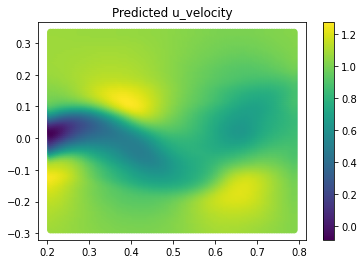

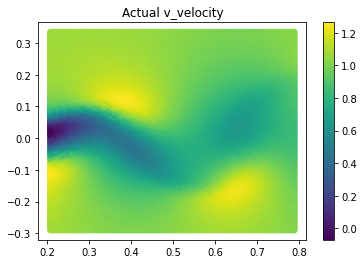

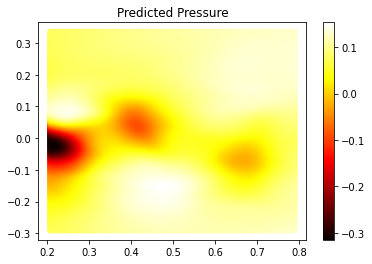

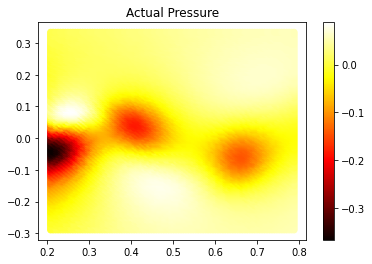

In [29]:
_,_=test_check_predictions(0.85,bc_pinn_model,True)

Errors at timestep: [0.03]
------------------------------------------------
Error u: 3.825733e-02
Error v: 2.198435e-01
Error p: 1.859471e-01


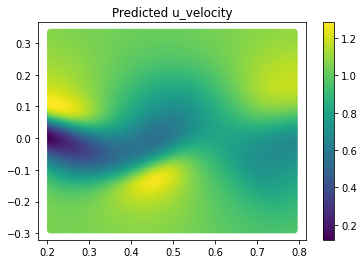

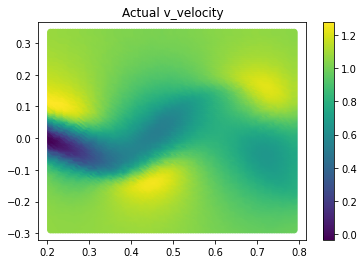

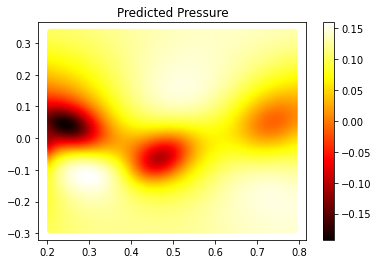

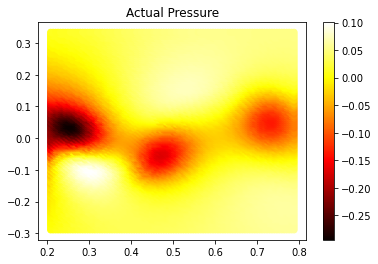

In [27]:
_,_=test_check_predictions(0.03,bc_pinn_model,True)

# Testing on Unseen dataset

In [22]:
def load_complete_data_mts():

    path=r"E:\Vamsi_oe20s302\Research work\Simulations and data\Unsteady trials\data\trials\Re100_data_more1"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()
    
    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()
    
    press=pd.read_csv(path+r"/press.csv")
    press=press.to_numpy()
    
    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()
    
    time=pd.read_csv(path+r"/time.csv")
    time=time.to_numpy()
    time=time-time[0]

    N=xy.shape[0]
    TT = np.tile(time, (1,N)).T # N x T
    
    # stores the data for each time step as a list
    data_list=[]
    
    for i in range(TT.shape[1]):
        if i<N:
            t=TT[:,i:i+1]
            u=uvel[:,i:i+1]
            v=vvel[:,i:i+1]
            p=press[:,i:i+1]
            a=np.concatenate([xy,t,u,v,p],1)
            data_list.append(a)
    
    return data_list

def load_testdata_mts(time_step):
    data_list=load_complete_data_mts()
    temp=[]
    for i in range(len(data_list)):
        if (np.unique(data_list[i][:,2]<7)):
            temp.append(data_list[i])
        else:
            break
    ts=int(time_step*100)
    data=temp[ts]
    
    x_star=data[:,0].reshape(data[:,0].shape[0],1)
    y_star=data[:,1].reshape(data[:,1].shape[0],1)
    t_star=data[:,2].reshape(data[:,2].shape[0],1)

    X_star=[x_star,y_star,t_star]

    u_star=data[:,3].reshape(data[:,3].shape[0],1)
    v_star=data[:,4].reshape(data[:,4].shape[0],1)
    p_star=data[:,5].reshape(data[:,5].shape[0],1)

    Y_star=[u_star,v_star,p_star]
        

    return X_star,Y_star


# This is the code snippet to randomly select intermediate timesteps for which the models have not been trained upon
# both the data driven model and the bc-pinn model
from tqdm import tqdm
e=[round(i,2) for i in np.arange(0,7,0.01)]
r=[round(i,2) for i in np.arange(0,7,0.01)]
f=[] # this is the list where the index of the required timesteps is stored.

for i in np.arange(0,7,0.1):
    e.pop(e.index(round(i,2)))
for i in range(len(e)):
    f.append(r.index(e[i]))

fg=[round((0.01*i),2) for i in f]


def save_test_error_data(file_name,eu):
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\Noisy_data\test_errors")
    my_path=root_path/file_name

    with open(my_path,'wb') as f:
        pickle.dump(eu,f)
        print("Errors are saved in pickle file")
def load_test_error_data(file_name):
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\Noisy_data\test_errors")
    my_path=root_path/file_name

    # returns the weights and biases of the network as np array
    with open(my_path,'rb') as f:
        eu_load=pickle.load(f)
    return eu_load


In [22]:
# This is for bcpinn-model

unseen_errors_bc_pinn=[]

for i in tqdm(fg):
    xstar,ystar=load_testdata_mts(i)
    x=xstar[0]
    y=xstar[1]
    t=xstar[2]
    u_pred,v_pred,_=bc_pinn_model.predict(x,y,t)

    error_u = np.linalg.norm(ystar[0] - u_pred, 2) / np.linalg.norm(ystar[0], 2)
    unseen_errors_bc_pinn.append(error_u)

100%|██████████████████████████████████████████████████████████████████████████████| 630/630 [1:22:52<00:00,  7.89s/it]


In [23]:
save_test_error_data('surrogate_1b1i1d',unseen_errors_bc_pinn)

Errors are saved in pickle file
